<a href="https://colab.research.google.com/github/BranislavMajernik/zerocode/blob/master/Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import pandas as pd
import os
import numpy as np
import pandas as pd
import datetime
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import glob

from google.colab import files
uploaded = files.upload()
df = pd.read_csv('data_load_test_testing_data.csv')
df.head()


Saving data_load_test_testing_data.csv to data_load_test_testing_data.csv


,timestamp,sensor1,sensor2,sensor3,sensor4
0,2020-08-29T14:42:46Z,1,2,3,4
1,2020-08-30T14:42:46Z,5,4,8,1
2,2020-08-31T14:42:46Z,8,1,2,4
3,2020-09-01T14:42:46Z,9,1,2,2
4,2020-09-02T14:42:46Z,8,5,6,1


In [58]:
df.tail()
df.nunique()


timestamp    80
sensor1       8
sensor2       8
sensor3       9
sensor4      18
dtype: int64

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sensor1,80.0,6.3000,2.664345,1.0,5.00,7.0,8.0,9.0
sensor2,80.0,4.6000,1.919916,1.0,4.00,5.0,6.0,8.0
sensor3,80.0,4.2750,2.412914,1.0,2.00,4.0,6.0,9.0
sensor4,80.0,37.0875,81.965907,1.0,1.75,5.0,8.0,330.0


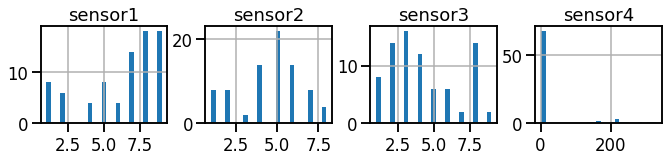

In [60]:
df.hist(df.columns, bins=25, layout=(8,7), figsize=(20, 18))
plt.show()

In [61]:
df_tidy = df.dropna()
import warnings
warnings.filterwarnings("ignore")
df_tidy['date'] = pd.to_datetime(df_tidy['timestamp'])
del df_tidy['timestamp']
df_tidy = df_tidy.set_index('date')
df_tidy.head()
df_tidy.to_csv('IOToutput.csv')

In [62]:
df=pd.read_csv('IOToutput.csv')

In [63]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.describe().T


,count,mean,std,min,25%,50%,75%,max
sensor1,80.0,6.3000,2.664345,1.0,5.00,7.0,8.0,9.0
sensor2,80.0,4.6000,1.919916,1.0,4.00,5.0,6.0,8.0
sensor3,80.0,4.2750,2.412914,1.0,2.00,4.0,6.0,9.0
sensor4,80.0,37.0875,81.965907,1.0,1.75,5.0,8.0,330.0


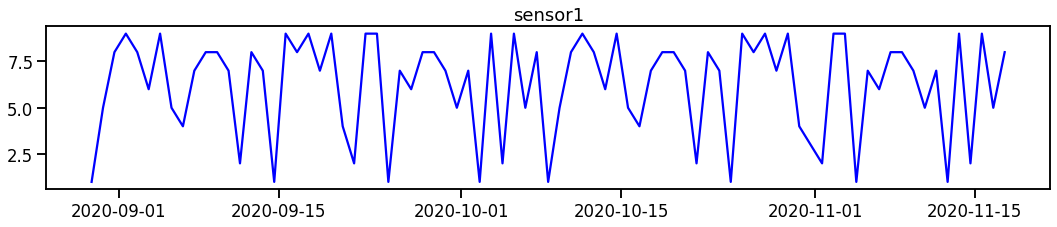

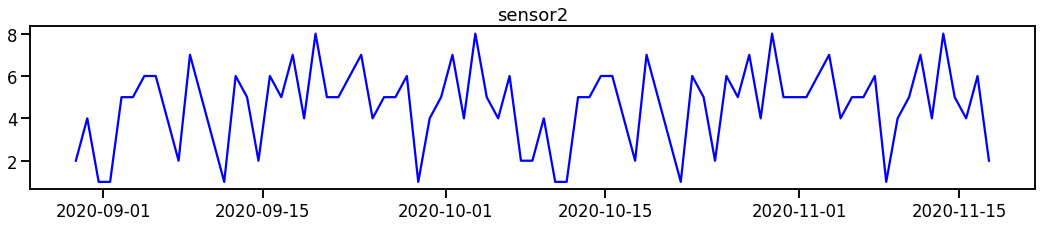

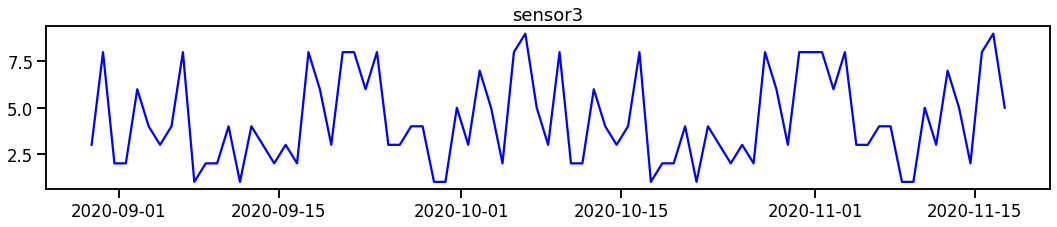

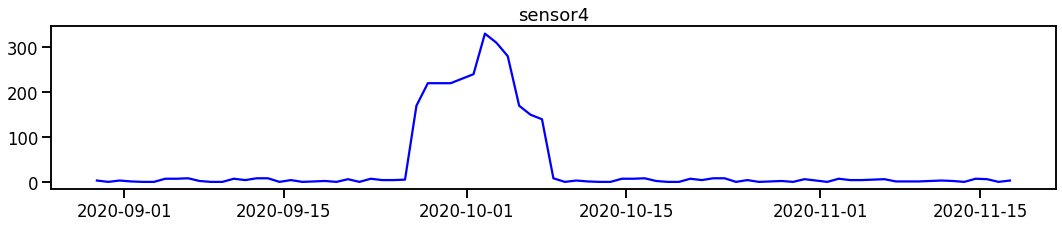

In [64]:
# Vizualize time series and the BROKEN state (red dots) in the same graph for each sensor
import warnings
names=df.columns
# Plot time series for each sensor with BROKEN state marked with X in red color
for name in names:
    sns.set_context('talk')
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(df[name], color='blue')
    _ = plt.title(name)
    plt.show()

In [65]:
rollmean = df.resample(rule='D').mean()
rollstd = df.resample(rule='D').std()

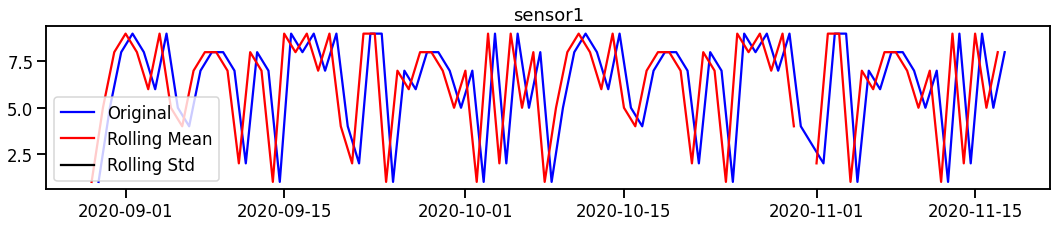

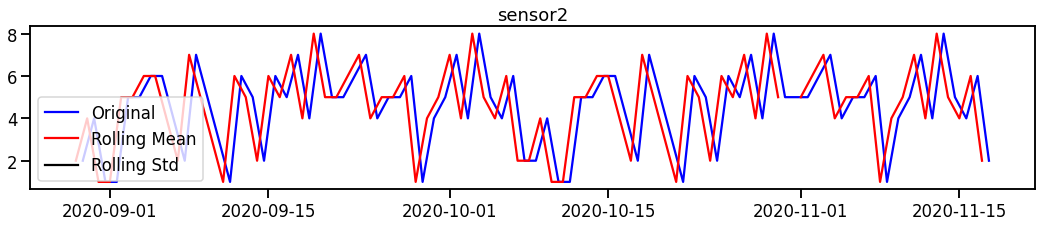

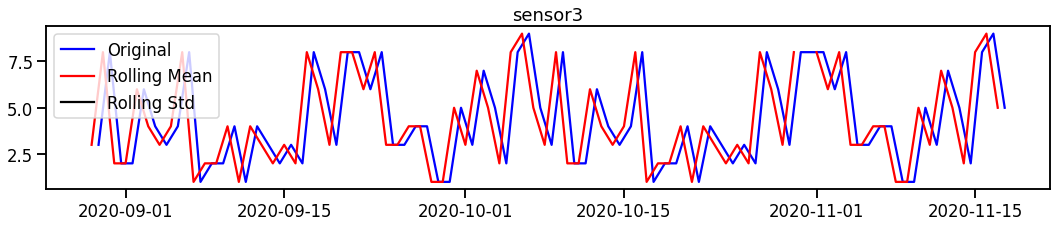

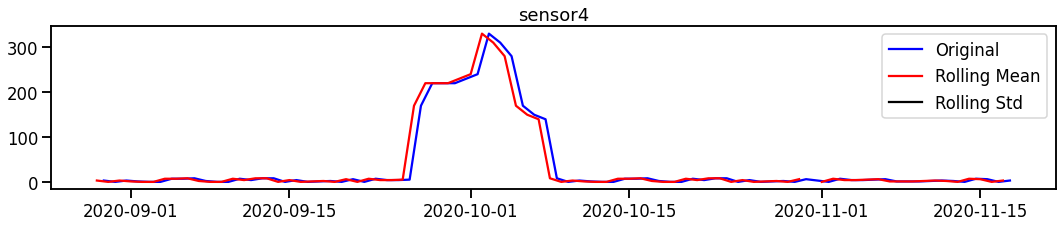

In [66]:

for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(df[name], color='blue', label='Original')
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# Extract the names of the numerical columns
names=df.columns
x = df[names]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

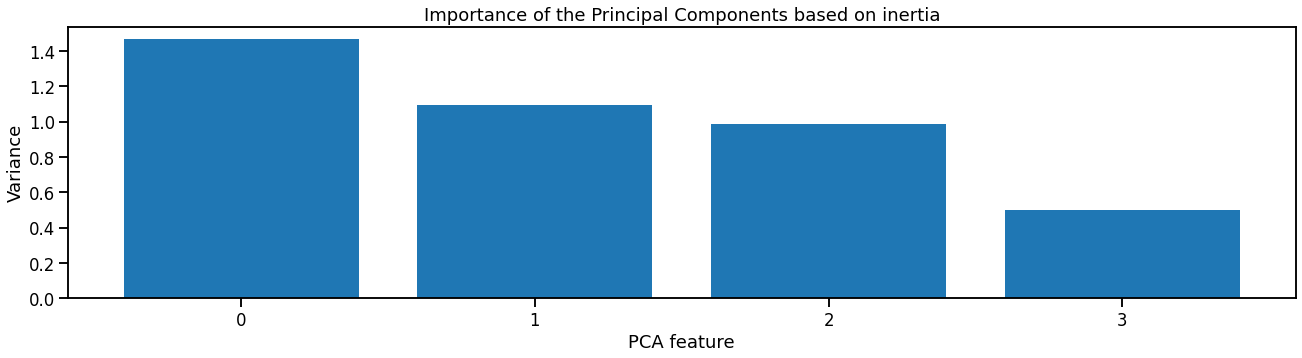

In [68]:
features = range(pca.n_components_)
_ = plt.figure(figsize=(22, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

In [69]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
df['pc1']=pd.Series(principalDf['pc1'].values, index=df.index)
df['pc2']=pd.Series(principalDf['pc2'].values, index=df.index)
df.head()

,sensor1,sensor2,sensor3,sensor4,pc1,pc2
date,,,,,,
2020-08-29 14:42:46+00:00,1,2,3,4,-33.082795,6.063418
2020-08-30 14:42:46+00:00,5,4,8,1,-36.084218,0.743969
2020-08-31 14:42:46+00:00,8,1,2,4,-33.097091,0.497145
2020-09-01 14:42:46+00:00,9,1,2,2,-35.098836,-0.384498
2020-09-02 14:42:46+00:00,8,5,6,1,-36.088901,-1.965393


In [70]:
# outlier_lower = Q1 - (1.5*IQR)
# outlier_upper = Q3 + (1.5*IQR)
# Calculate outlier bounds for pc1
q1_pc1, q3_pc1 = df['pc1'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
# Calculate outlier bounds for pc2
q1_pc2, q3_pc2 = df['pc2'].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2
lower_pc2 = q1_pc2 - (1.5*iqr_pc2)
upper_pc2 = q3_pc2 + (1.5*iqr_pc2)

In [71]:
df['anomaly_pc1'] = ((df['pc1']>upper_pc1) | (df['pc1']<lower_pc1)).astype('int')
df['anomaly_pc2'] = ((df['pc2']>upper_pc2) | (df['pc2']<lower_pc2)).astype('int')
df['anomaly_pc1'].value_counts()
df['anomaly_pc2'].value_counts()
outliers_pc1 = df.loc[(df['pc1']>upper_pc1) | (df['pc1']<lower_pc1), 'pc1']
outliers_pc2 = df.loc[(df['pc2']>upper_pc2) | (df['pc2']<lower_pc2), 'pc2']

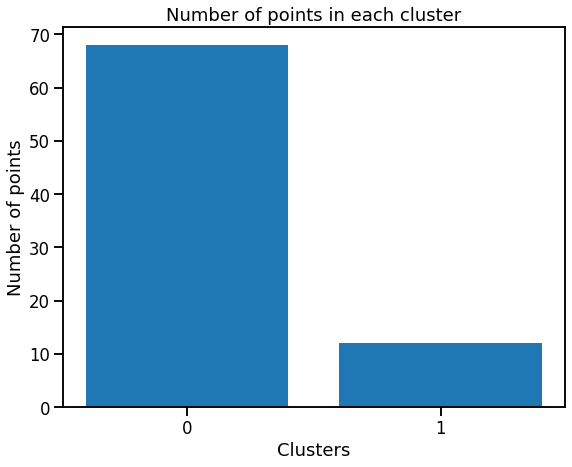

In [72]:
# Import necessary libraries
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(principalDf.values)
labels = kmeans.predict(principalDf.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))
_ = plt.figure(figsize = (9, 7))
_ = plt.bar(clusters[0], clusters[1], tick_label=clusters[0])
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Number of points')
_ = plt.title('Number of points in each cluster')
plt.show()


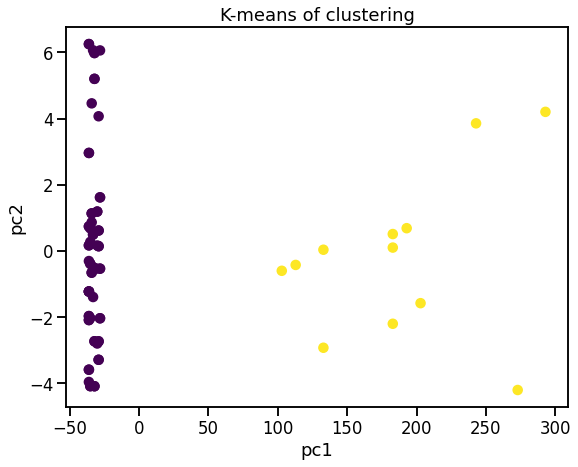

In [73]:
_ = plt.figure(figsize=(9,7))
_ = plt.scatter(principalDf['pc1'], principalDf['pc2'], c=labels)
_ = plt.xlabel('pc1')
_ = plt.ylabel('pc2')
_ = plt.title('K-means of clustering')
plt.show()


In [74]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)
# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.13
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['anomaly1'] = (distance >= threshold).astype(int)
principalDf.head()

,pc1,pc2,anomaly1
0,-33.082795,6.063418,0
1,-36.084218,0.743969,0
2,-33.097091,0.497145,0
3,-35.098836,-0.384498,0
4,-36.088901,-1.965393,0


In [75]:
principalDf['anomaly1'].value_counts()

0    70
1    10
Name: anomaly1, dtype: int64

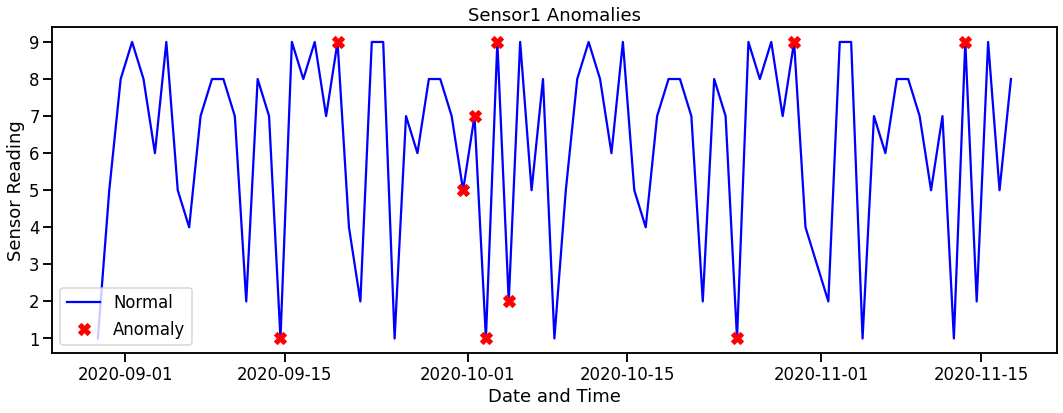

In [76]:
df['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=df.index)
a = df[df['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor1'], color='blue', label='Normal')
_ = plt.plot(a['sensor1'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor1 Anomalies')
_ = plt.legend(loc='best')
plt.show();

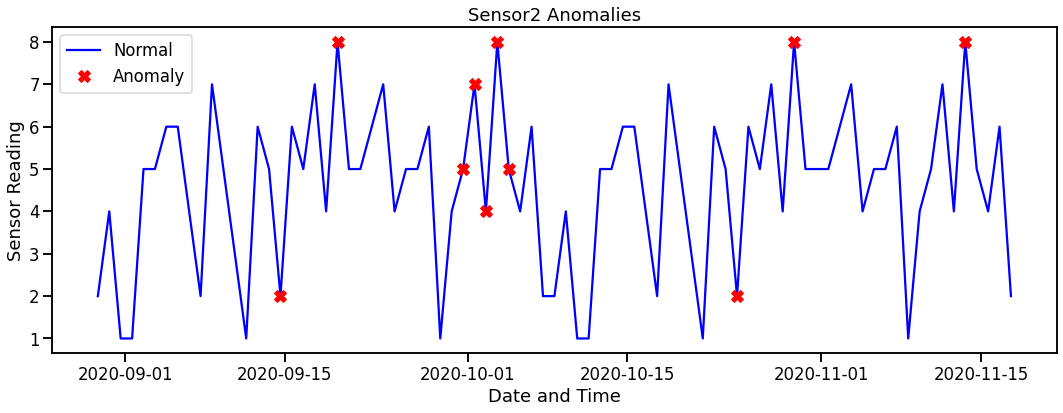

In [77]:
a = df[df['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor2'], color='blue', label='Normal')
_ = plt.plot(a['sensor2'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor2 Anomalies')
_ = plt.legend(loc='best')
plt.show();

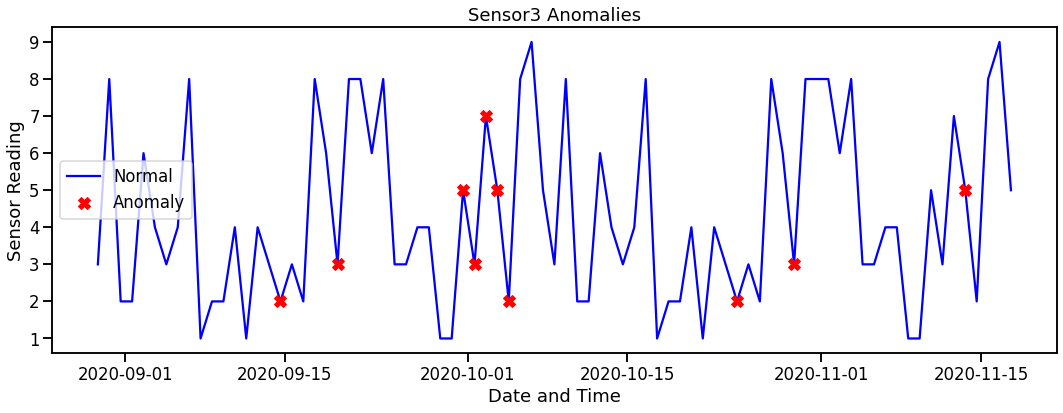

In [78]:
a = df[df['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor3'], color='blue', label='Normal')
_ = plt.plot(a['sensor3'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor3 Anomalies')
_ = plt.legend(loc='best')
plt.show();

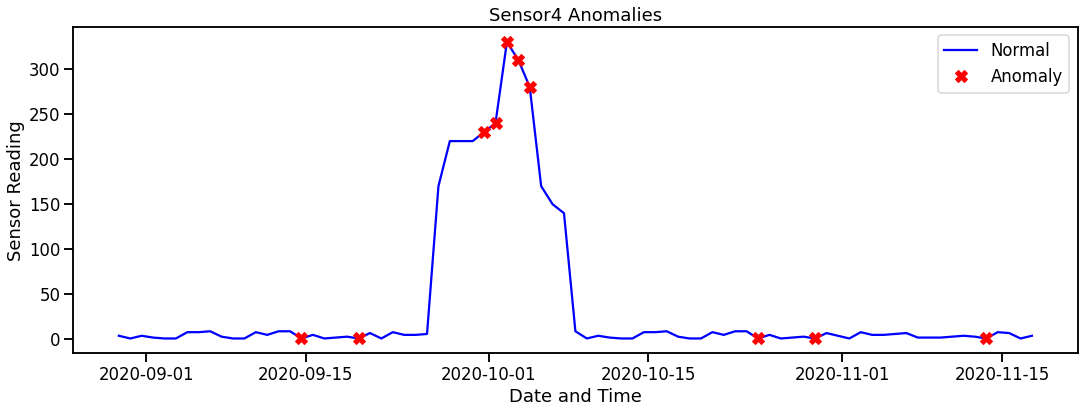

In [79]:
a = df[df['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor4'], color='blue', label='Normal')
_ = plt.plot(a['sensor4'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor4 Anomalies')
_ = plt.legend(loc='best')
plt.show();

In [80]:
# Import IsolationForest
from sklearn.ensemble import IsolationForest
# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.13
model =  IsolationForest(contamination=outliers_fraction)
model.fit(principalDf.values) 
principalDf['anomaly2'] = pd.Series(model.predict(principalDf.values))

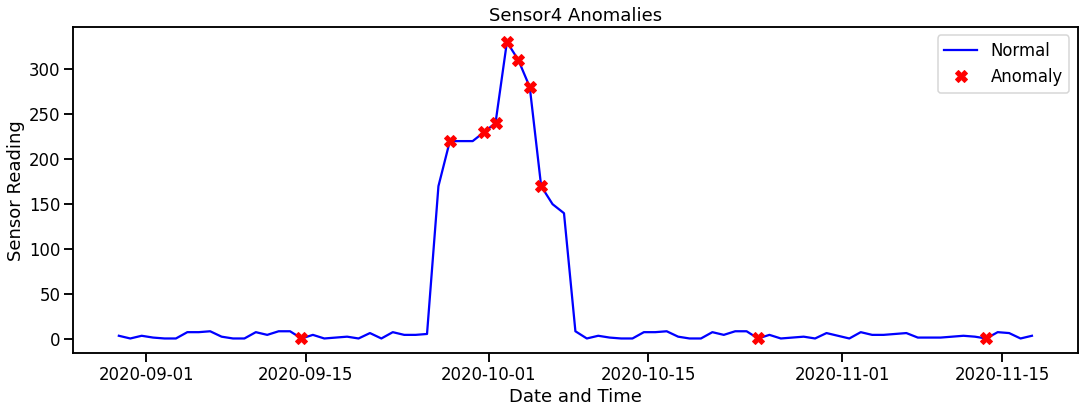

In [82]:
df['anomaly2'] = pd.Series(principalDf['anomaly2'].values, index=df.index)
a = df.loc[df['anomaly2'] == -1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor4'], color='blue', label='Normal')
_ = plt.plot(a['sensor4'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor4 Anomalies')
_ = plt.legend(loc='best')
plt.show();